In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from torchvision import datasets ,models,transforms
import os
import matplotlib.image as img

from torch.utils.data import Dataset, DataLoader
#from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module

import pickle
import math
from app import *
import tqdm
from tqdm import trange

In [4]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
#device='cpu'

device(type='cuda', index=0)

# Load data

In [5]:
with open('../data_pickle/resized_train_data.pickle', 'rb') as f :
    train = pickle.load(f)
with open('../data_pickle/resized_valid_data.pickle', 'rb') as f :
    valid = pickle.load(f)
with open('../data_pickle/resized_test_data.pickle', 'rb') as f :
    test = pickle.load(f)

In [6]:
X_train = np.array(train['train_data'])
Y_train = np.array(train['train_label'])
X_val = np.array(valid['valid_data'])
Y_val = np.array(valid['valid_label'])
X_test = np.array(test['test_data'])
Y_test = np.array(test['test_label'])

In [7]:
X_train = np.transpose(X_train,(0,3,1,2))
X_val = np.transpose(X_val,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))

In [8]:
from app import Net

In [16]:
class Conv:
    	# 初始化权重（卷积核4维）、偏置、步幅、填充
    def __init__(self, Cin, Cout, X_H, X_W, F, stride, pad):

        self.stride = stride
        self.pad = pad
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.X_H = X_H
        self.X_W = X_W
        self.Cin = Cin

    def _forward(self, x):
        x = x.reshape(x.shape[0], self.Cin, self.X_H, self.X_W)
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        # 数据数据大小
        N, C, H, W = x.shape
        # 计算输出数据大小
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        # 利用im2col转换为行
        col = im2col(x, FH, FW, self.stride, self.pad)
        # 卷积核转换为列，展开为2维数组
        col_W = self.W['val'].reshape(FN, -1).T
        # 计算正向传播
        out = np.dot(col, col_W) + self.b['val']
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def _backward(self, dout):
        # 卷积核大小
        FN, C, FH, FW = self.W['val'].shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        db = np.sum(dout, axis=0)
        dW = np.dot(self.col.T, dout)
        dW = dW.transpose(1, 0).reshape(FN, C, FH, FW)

        self.W['grad'] = dW
        self.b['grad'] = db

        dcol = np.dot(dout, self.col_W.T)
        # 逆转换
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    # 输入数据的形状
    # N：批数目，C：通道数，H：输入数据高，W：输入数据长
    N, C, H, W = input_data.shape  
    out_h = (H + 2*pad - filter_h)//stride + 1  # 输出数据的高
    out_w = (W + 2*pad - filter_w)//stride + 1  # 输出数据的长
    # 填充 H,W
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # (N, C, filter_h, filter_w, out_h, out_w)的0矩阵
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    # 按(0, 4, 5, 1, 2, 3)顺序，交换col的列，然后改变形状
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [10]:
class MaxPool:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def _forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
		# 展开
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
		# 最大值
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 转换
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def _backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


In [11]:
class LeNet5(Net):
    # LeNet5

    def __init__(self):
        #self.conv1 = Conv(3, 6, 3)  #64>62
        self.conv1 = Conv(3, 6, 64, 64, 3, 1, 0)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2)   #62>31
        #self.conv2 = Conv(6, 16, 4)  #31>28
        self.conv2 = Conv(6, 16, 31, 31, 4, 1, 0)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2,2) #28>14
        self.FC1 = FC(16*14*14, 512)
        self.ReLU3 = ReLU()
        self.FC2 = FC(512, 256)
        self.ReLU4 = ReLU()
        self.FC3 = FC(256, 128)
        self.ReLU5 = ReLU()
        self.FC4 = FC(128, 50)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        #add layer
        a6 = self.ReLU5._forward(h5)
        h6 = self.FC4._forward(a6)
        
        a7 = self.Softmax._forward(h6)
        return a7

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        #add layer
        dout = self.FC4._backward(dout)
        dout = self.ReLU5._backward(dout)
        
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params


In [12]:
model = LeNet5()
losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

In [13]:
batch_size = 100

In [37]:
len(X_batch[0]), len(X_batch[0][0]), len(X_batch[0][0][0]), type(X_batch)

(3, 64, 64, numpy.ndarray)

In [14]:
from tqdm import trange

In [15]:
ITER = 5000
for i in trange(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    Y_batch = MakeOneHot(Y_batch, 50)

    # forward, loss, backward, step
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch)
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)


# save params
weights = model.get_params()
with open("weights.pkl","wb") as f:
    pickle.dump(weights, f)

draw_losses(losses)



  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'col2im' is not defined

In [18]:
with open("weights.pkl",'rb') as f:
        weights = pickle.load(f)

In [19]:
 model.set_params

<bound method LeNet5.set_params of <__main__.LeNet5 object at 0x7f0ee4b884a8>>

In [20]:
test_size = 100
print("test_size = " + str(test_size))
X_train_min, Y_train_min = get_batch(X_train, Y_train, test_size)
X_test_min,  Y_test_min  = get_batch(X_test,  Y_test,  test_size)

# TRAIN SET ACC
Y_pred_min = model.forward(X_train_min)
result = np.argmax(Y_pred_min, axis=1) - Y_train_min
result = list(result)
print("TRAIN--> Correct: " + str(result.count(0)) + " out of " + str(X_train_min.shape[0]) + ", acc=" + str(result.count(0)/X_train_min.shape[0]))

# TEST SET ACC
Y_pred_min = model.forward(X_test_min)
result = np.argmax(Y_pred_min, axis=1) - Y_test_min
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test_min.shape[0]) + ", acc=" + str(result.count(0)/X_test_min.shape[0]))

test_size = 100
TRAIN--> Correct: 0 out of 100, acc=0.0
TEST--> Correct: 0 out of 100, acc=0.0


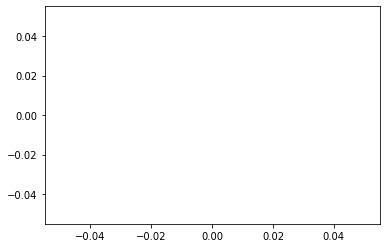

In [21]:
draw_losses(losses)

In [ ]:


print("batch_size: " + str(batch_size) + ", D_in: " + str(D_in) + ", D_out: " + str(D_out))

### TWO LAYER NET FORWARD TEST ###
#H=400
#model = nn.TwoLayerNet(batch_size, D_in, H, D_out)
H1=300
H2=100
model = ThreeLayerNet(batch_size, D_in, H1, H2, D_out)


losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

# TRAIN
ITER = 25000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    Y_batch = MakeOneHot(Y_batch, D_out)

    # forward, loss, backward, step
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch)
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)


# save params
weights = model.get_params()
with open("weights.pkl","wb") as f:
    pickle.dump(weights, f)

draw_losses(losses)



# TRAIN SET ACC
Y_pred = model.forward(X_train)
result = np.argmax(Y_pred, axis=1) - Y_train
result = list(result)
print("TRAIN--> Correct: " + str(result.count(0)) + " out of " + str(X_train.shape[0]) + ", acc=" + str(result.count(0)/X_train.shape[0]))

# TEST SET ACC
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))


In [ ]:
fig = plt.figure()
#x = list(range(0, len(train_acc) * 50, 50))
ax = sns.lineplot(x = x, y = train_acc_list, color='seagreen', label = 'Train Top 1 accuracy')
sns.lineplot(x = x, y = train_acc_5_list, color='royalblue', label = 'Train Top 5 accuracy')
sns.lineplot(x = x, y = valid_acc_list, color='red', label = 'Validation Top 1 accuracy')
sns.lineplot(x = x, y = valid_acc_5_list, color='gold', label = 'Validation Top 5 accuracy')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Accuracy", size = 14)
ax.set_title("Train vs Validation", size = 14, fontweight='bold')
ax.legend()
fig.set_figheight(6)
fig.set_figwidth(16)